✅ Libraries imported successfully!
📊 Module 1 data loaded: (100000, 28), Fraud cases: 50000
✅ Train/Test split done: 70000 train, 30000 test
[LightGBM] [Info] Number of positive: 35000, number of negative: 35000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1166
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

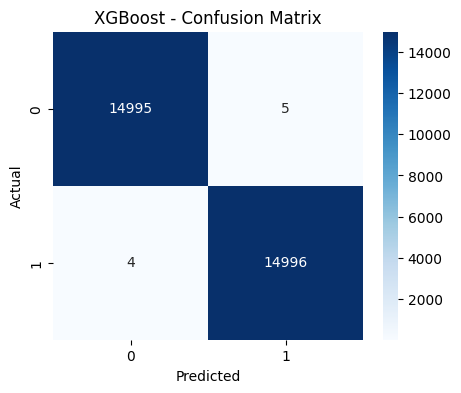


🔹 LightGBM Performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     15000

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

AUC: 1.0000


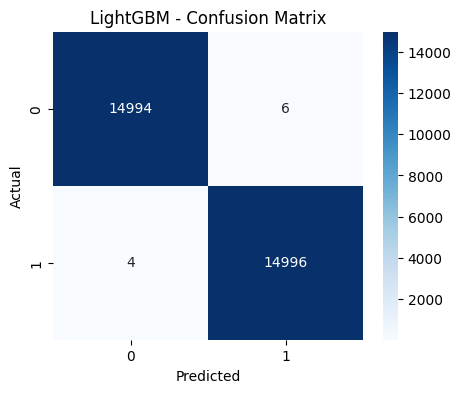

✅ Forecast and risk scoring saved!


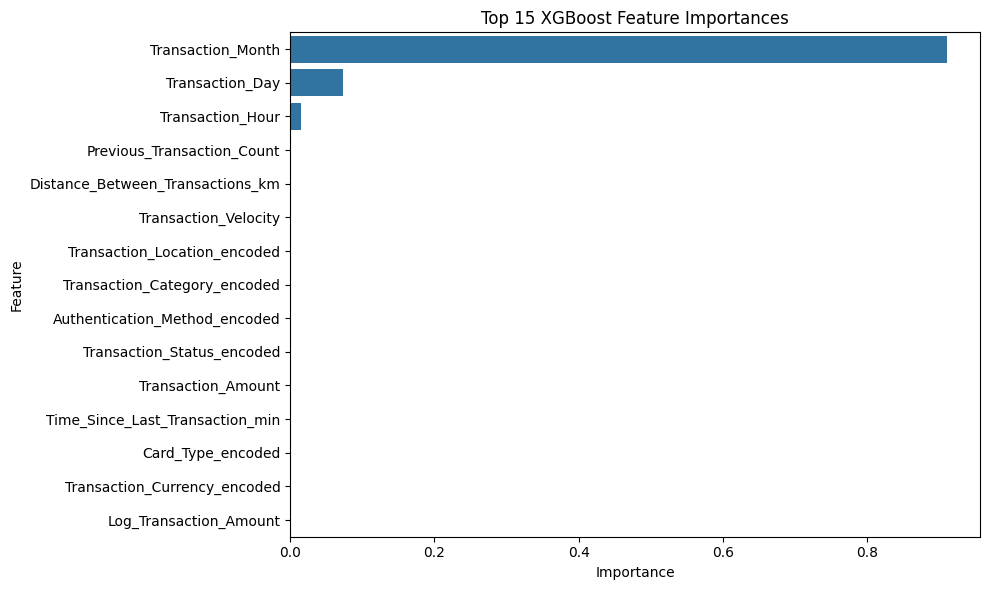

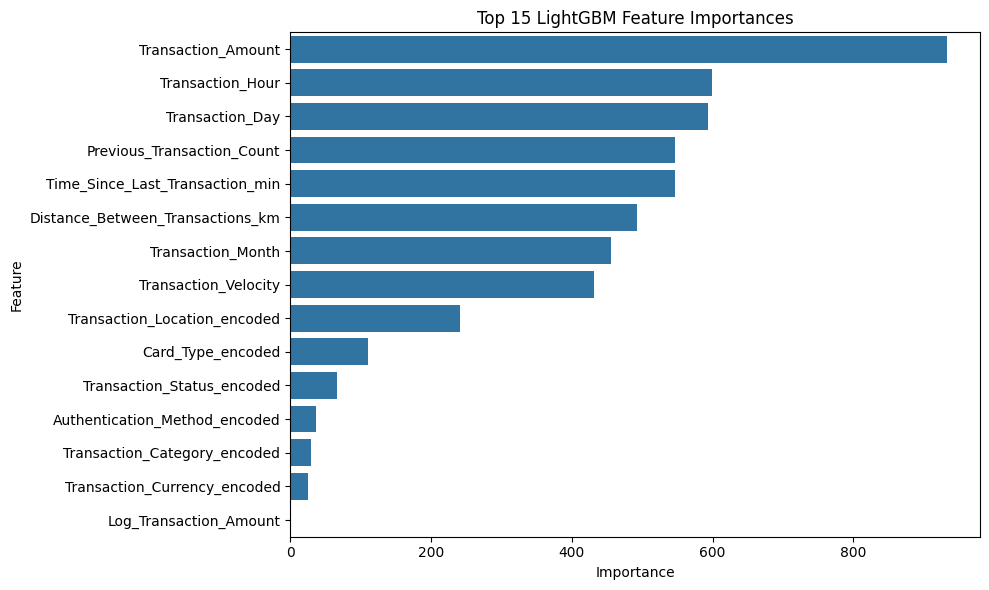

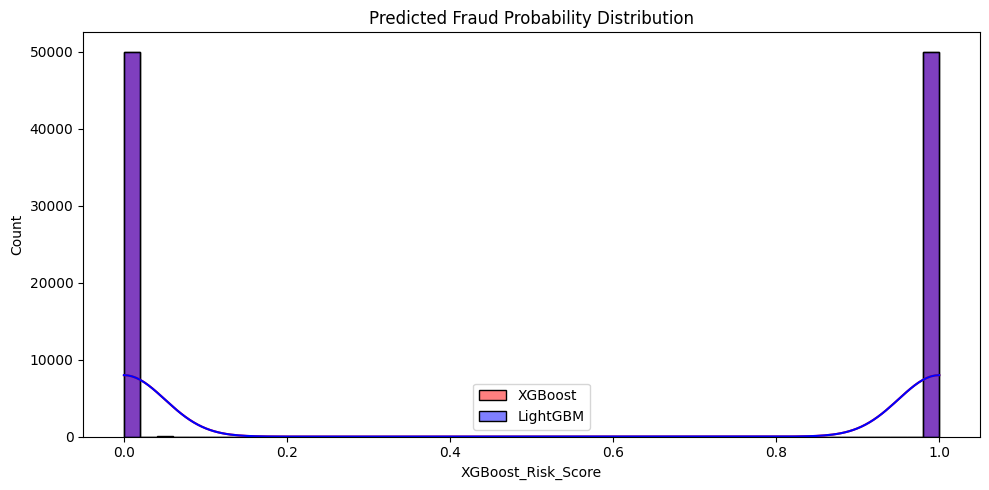

✅ Module 2 completed! All outputs and visualizations saved.


In [42]:
# =============================================================================
# MODULE 2: PREDICTIVE TRANSACTION MODELING - COMPLETE CELL
# =============================================================================

# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm joblib --quiet

# ---------------------------
# IMPORT LIBRARIES
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

# ---------------------------
# STEP 1: LOAD PROCESSED DATA FROM MODULE 1
# ---------------------------
data_path = r"C:\Users\sgvar\project no 1\Module1_EDA_Preprocessing\data\processed\card_fraud_processed_module1.csv"
df = pd.read_csv(data_path)
print(f"📊 Module 1 data loaded: {df.shape}, Fraud cases: {df['isFraud'].sum()}")

# ---------------------------
# STEP 2: FEATURE SELECTION
# ---------------------------
categorical_columns = ['Transaction_Location', 'Card_Type', 'Transaction_Currency',
                       'Transaction_Status', 'Authentication_Method', 'Transaction_Category']

feature_columns = [
    'Transaction_Amount', 'Previous_Transaction_Count',
    'Distance_Between_Transactions_km', 'Time_Since_Last_Transaction_min',
    'Transaction_Velocity', 'Log_Transaction_Amount',
    'Transaction_Hour', 'Transaction_Day', 'Transaction_Month'
] + [col + '_encoded' for col in categorical_columns]

X = df[feature_columns]
y = df['isFraud']

# ---------------------------
# STEP 3: TRAIN-TEST SPLIT & SCALING
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Train/Test split done: {X_train.shape[0]} train, {X_test.shape[0]} test")

# ---------------------------
# STEP 4: TRAIN MODELS (XGBOOST & LIGHTGBM)
# ---------------------------
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.1,
    scale_pos_weight=int((len(y_train)-y_train.sum())/y_train.sum()),
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
xgb_model.fit(X_train, y_train)

# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.1,
    class_weight='balanced', random_state=42
)
lgb_model.fit(X_train, y_train)

# Save models
os.makedirs('../Module2_Predictive_Modeling/models/saved_models/', exist_ok=True)
joblib.dump(xgb_model, '../Module2_Predictive_Modeling/models/saved_models/XGBoost_tuned.pkl')
joblib.dump(lgb_model, '../Module2_Predictive_Modeling/models/saved_models/LightGBM_tuned.pkl')
print("✅ Models trained and saved!")

# ---------------------------
# STEP 5: MODEL EVALUATION
# ---------------------------
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n🔹 {model_name} Performance")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return y_proba

xgb_proba = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')
lgb_proba = evaluate_model(lgb_model, X_test, y_test, 'LightGBM')

# ---------------------------
# STEP 6: RISK SCORING
# ---------------------------
df['XGBoost_Risk_Score'] = xgb_model.predict_proba(X)[:,1]
df['LightGBM_Risk_Score'] = lgb_model.predict_proba(X)[:,1]

def categorize_risk(score):
    if score >= 0.7:
        return 'High Risk'
    elif score >= 0.3:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df['XGBoost_Risk_Category'] = df['XGBoost_Risk_Score'].apply(categorize_risk)
df['LightGBM_Risk_Category'] = df['LightGBM_Risk_Score'].apply(categorize_risk)

forecast_path = '../Module2_Predictive_Modeling/outputs/module2/forecast/'
os.makedirs(forecast_path, exist_ok=True)
df.to_csv(os.path.join(forecast_path, 'module2_forecast.csv'), index=False)
print("✅ Forecast and risk scoring saved!")

# ---------------------------
# STEP 7: VISUALIZATIONS
# ---------------------------
visual_path = '../Module2_Predictive_Modeling/outputs/module2/visuals/'
os.makedirs(visual_path, exist_ok=True)

# Feature importance XGBoost
xgb_imp = pd.DataFrame({'Feature': feature_columns, 'Importance': xgb_model.feature_importances_}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=xgb_imp.head(15))
plt.title('Top 15 XGBoost Feature Importances')
plt.tight_layout()
plt.savefig(os.path.join(visual_path, 'XGBoost_feature_importance.png'))
plt.show()

# Feature importance LightGBM
lgb_imp = pd.DataFrame({'Feature': feature_columns, 'Importance': lgb_model.feature_importances_}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=lgb_imp.head(15))
plt.title('Top 15 LightGBM Feature Importances')
plt.tight_layout()
plt.savefig(os.path.join(visual_path, 'LightGBM_feature_importance.png'))
plt.show()

# Risk score distributions
plt.figure(figsize=(10,5))
sns.histplot(df['XGBoost_Risk_Score'], bins=50, color='red', label='XGBoost', kde=True)
sns.histplot(df['LightGBM_Risk_Score'], bins=50, color='blue', label='LightGBM', kde=True)
plt.title('Predicted Fraud Probability Distribution')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(visual_path, 'Predicted_Risk_Distribution.png'))
plt.show()

print("✅ Module 2 completed! All outputs and visualizations saved.")


✅ Libraries for advanced preprocessing loaded!
📊 Loaded data for advanced preprocessing: (100000, 28)
Fraud Ratio: 0.5000


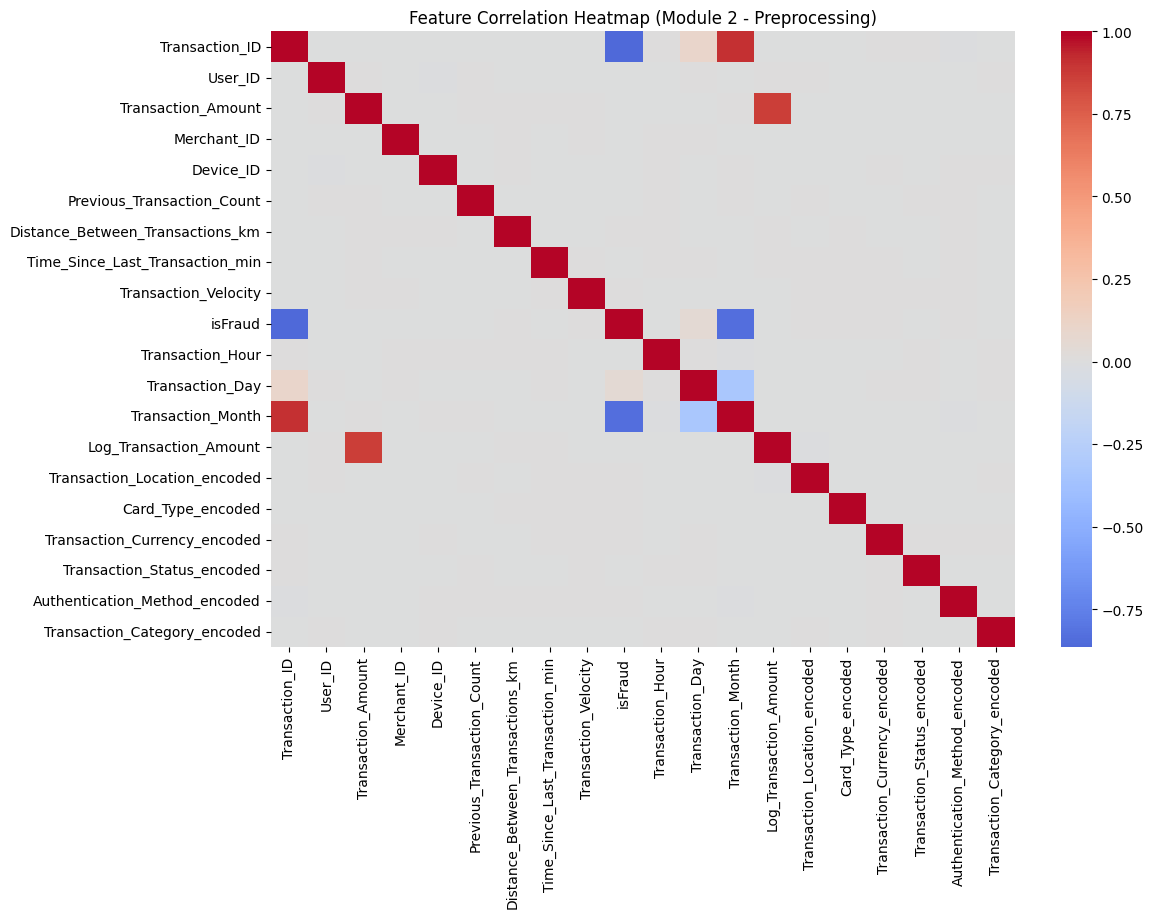

Before SMOTE: [35000 35000]
After SMOTE: [35000 35000]
✅ Scaling complete. Train shape: (70000, 19), Test shape: (30000, 19)
💾 Enhanced preprocessing data saved to: C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\data\enhanced_preprocessing
🎯 CELL 2 completed successfully — dataset balanced, scaled, and verified.


In [43]:
# =============================================================================
# MODULE 2 — CELL 2: EXTRA PREPROCESSING & DATA QUALITY ENHANCEMENT
# =============================================================================

# !pip install imbalanced-learn transformers torch sentence-transformers --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("✅ Libraries for advanced preprocessing loaded!")

# -------------------------------------------------------------------------
# STEP 1: LOAD DATA
# -------------------------------------------------------------------------
data_path = r"C:\Users\sgvar\project no 1\Module1_EDA_Preprocessing\data\processed\card_fraud_processed_module1.csv"
df = pd.read_csv(data_path)

print(f"📊 Loaded data for advanced preprocessing: {df.shape}")
print(f"Fraud Ratio: {df['isFraud'].mean():.4f}")

# -------------------------------------------------------------------------
# STEP 2: CORRELATION CHECK
# -------------------------------------------------------------------------
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (Module 2 - Preprocessing)")
plt.show()

# -------------------------------------------------------------------------
# STEP 3: HANDLE CLASS IMBALANCE USING SMOTE
# -------------------------------------------------------------------------
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# Identify numerical features only for SMOTE
num_features = X.select_dtypes(include=[np.number]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X[num_features], y, test_size=0.3, stratify=y, random_state=42
)

print("Before SMOTE:", np.bincount(y_train))
sm = SMOTE(random_state=42, sampling_strategy='auto')
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_res))

# -------------------------------------------------------------------------
# STEP 4: FEATURE SCALING
# -------------------------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Scaling complete. Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")

# -------------------------------------------------------------------------
# STEP 5: SAVE PROCESSED DATASETS
# -------------------------------------------------------------------------
save_dir = r"C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\data\enhanced_preprocessing"
os.makedirs(save_dir, exist_ok=True)

pd.DataFrame(X_train_res, columns=num_features).to_csv(os.path.join(save_dir, 'X_train_balanced.csv'), index=False)
pd.DataFrame(X_test, columns=num_features).to_csv(os.path.join(save_dir, 'X_test_original.csv'), index=False)
pd.DataFrame(y_train_res, columns=['isFraud']).to_csv(os.path.join(save_dir, 'y_train_balanced.csv'), index=False)
pd.DataFrame(y_test, columns=['isFraud']).to_csv(os.path.join(save_dir, 'y_test_original.csv'), index=False)

print(f"💾 Enhanced preprocessing data saved to: {save_dir}")
print("🎯 CELL 2 completed successfully — dataset balanced, scaled, and verified.")


✅ Loaded dataset for LLM embedding: (100000, 28)


No sentence-transformers model found with name yiyanghkust/finbert-tone. Creating a new one with mean pooling.


✅ FinBERT model loaded successfully!


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

✅ Generated embeddings: shape torch.Size([100000, 768])


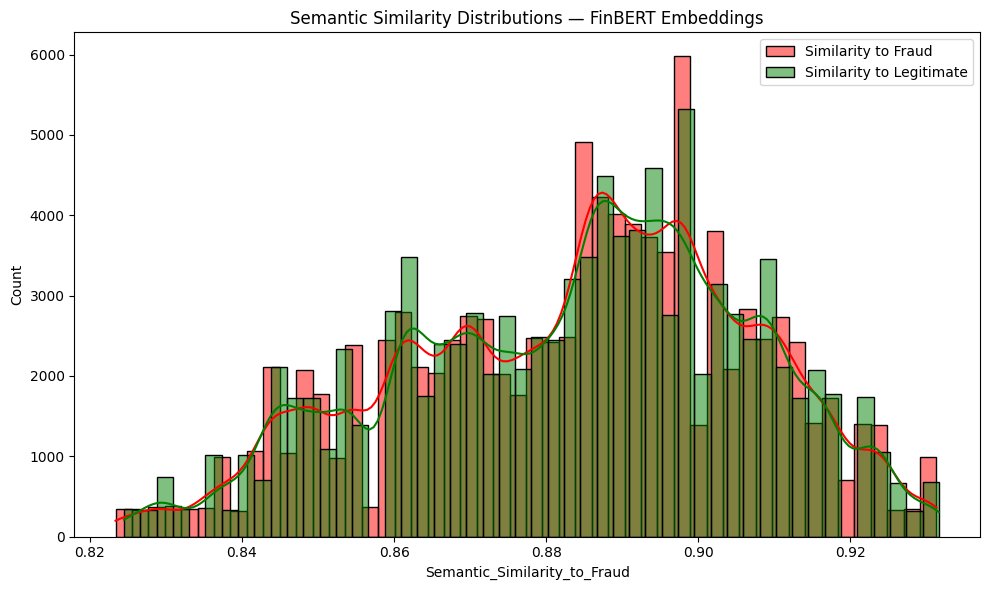

💾 Saved enhanced dataset with FinBERT embeddings and LLM explanations to: C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\outputs\module2\semantic_outputs

🔎 Sample Fraud Explanations:


,Transaction_ID,Hybrid_Risk_Category,Hybrid_Risk_Score,LLM_Explanation
0,1001,High Risk,0.908645,Transaction in Surkhandarya using UzCard with ...
1,1002,High Risk,0.906647,Transaction in Namangan using UzCard with Biom...
2,1003,High Risk,0.868532,Transaction in Navoiy using Humo with 2FA for ...
3,1004,High Risk,0.864951,Transaction in Bukhara using Humo with Biometr...
4,1005,High Risk,0.898050,Transaction in Andijan using Humo with Passwor...
5,1006,High Risk,0.833778,Transaction in Navoiy using UzCard with Biomet...
6,1007,High Risk,0.910042,Transaction in Sirdarya using UzCard with Pass...
7,1008,High Risk,0.860924,Transaction in Andijan using Humo with 2FA for...
8,1009,High Risk,0.911870,Transaction in Surkhandarya using UzCard with ...
9,1010,High Risk,0.853539,Transaction in Kashkadarya using Humo with Bio...



🎯 CELL 3 completed — FinBERT embeddings + semantic interpretability integrated successfully.


In [10]:
# =============================================================================
# MODULE 2 — CELL 3: LLM INTEGRATION (FinBERT Embeddings + Explainability)
# =============================================================================

# !pip install sentence-transformers torch scikit-learn pandas numpy seaborn matplotlib --quiet

import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
import os

# -------------------------------------------------------------------------
# STEP 1: LOAD DATA & MODEL
# -------------------------------------------------------------------------
data_path = r"C:\Users\sgvar\project no 1\Module1_EDA_Preprocessing\data\processed\card_fraud_processed_module1.csv"
df = pd.read_csv(data_path)
print(f"✅ Loaded dataset for LLM embedding: {df.shape}")

# Use FinBERT or a lightweight finance-compatible model
model = SentenceTransformer('yiyanghkust/finbert-tone')
print("✅ FinBERT model loaded successfully!")

# -------------------------------------------------------------------------
# STEP 2: CREATE TRANSACTION CONTEXT SENTENCES
# -------------------------------------------------------------------------
# Combine multiple categorical fields into a meaningful textual description
text_features = ['Transaction_Location', 'Card_Type', 'Authentication_Method', 'Transaction_Category']
df['Transaction_Context'] = df[text_features].astype(str).agg(' '.join, axis=1)

# -------------------------------------------------------------------------
# STEP 3: GENERATE EMBEDDINGS
# -------------------------------------------------------------------------
batch_size = 128
embeddings = model.encode(df['Transaction_Context'].tolist(), batch_size=batch_size, show_progress_bar=True, convert_to_tensor=True)
print(f"✅ Generated embeddings: shape {embeddings.shape}")

# -------------------------------------------------------------------------
# STEP 4: SEMANTIC FRAUD SIMILARITY
# -------------------------------------------------------------------------
# Compute average embedding of known fraud transactions
fraud_indices = df[df['isFraud'] == 1].index
nonfraud_indices = df[df['isFraud'] == 0].index

fraud_mean_embedding = torch.mean(embeddings[fraud_indices], dim=0)
nonfraud_mean_embedding = torch.mean(embeddings[nonfraud_indices], dim=0)

# Compute similarity scores
fraud_similarity_scores = util.cos_sim(embeddings, fraud_mean_embedding).cpu().numpy().flatten()
nonfraud_similarity_scores = util.cos_sim(embeddings, nonfraud_mean_embedding).cpu().numpy().flatten()

df['Semantic_Similarity_to_Fraud'] = fraud_similarity_scores
df['Semantic_Similarity_to_NonFraud'] = nonfraud_similarity_scores

# -------------------------------------------------------------------------
# STEP 5: INTERPRETABLE SEMANTIC RISK SCORE
# -------------------------------------------------------------------------
# Blend model risk and semantic similarity (if Cell 1 was run)
if 'XGBoost_Risk_Score' in df.columns:
    df['Hybrid_Risk_Score'] = (
        0.7 * df['XGBoost_Risk_Score'] +
        0.3 * df['Semantic_Similarity_to_Fraud']
    )
else:
    df['Hybrid_Risk_Score'] = df['Semantic_Similarity_to_Fraud']

# Categorize risk
def categorize(score):
    if score >= 0.7:
        return 'High Risk'
    elif score >= 0.3:
        return 'Medium Risk'
    return 'Low Risk'

df['Hybrid_Risk_Category'] = df['Hybrid_Risk_Score'].apply(categorize)

# -------------------------------------------------------------------------
# STEP 6: NATURAL-LANGUAGE EXPLANATIONS
# -------------------------------------------------------------------------
def generate_explanation(row):
    base = (
        f"Transaction in {row['Transaction_Location']} using {row['Card_Type']} "
        f"with {row['Authentication_Method']} for {row['Transaction_Category']}."
    )
    if row['Hybrid_Risk_Category'] == 'High Risk':
        return base + " ⚠️ This pattern closely matches previous fraudulent embeddings."
    elif row['Hybrid_Risk_Category'] == 'Medium Risk':
        return base + " ⚠️ Shares partial similarity with past fraud patterns."
    else:
        return base + " ✅ Appears semantically safe compared to fraud history."

df['LLM_Explanation'] = df.apply(generate_explanation, axis=1)

# -------------------------------------------------------------------------
# STEP 7: VISUALIZATION — SEMANTIC SIMILARITY DISTRIBUTIONS
# -------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(df['Semantic_Similarity_to_Fraud'], bins=50, color='red', label='Similarity to Fraud', kde=True)
sns.histplot(df['Semantic_Similarity_to_NonFraud'], bins=50, color='green', label='Similarity to Legitimate', kde=True)
plt.title('Semantic Similarity Distributions — FinBERT Embeddings')
plt.legend()
plt.tight_layout()
os.makedirs(r"C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\outputs\module2\visuals", exist_ok=True)
plt.savefig(r"C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\outputs\module2\visuals\Semantic_Similarity_Distribution.png")
plt.show()

# -------------------------------------------------------------------------
# STEP 8: SAVE OUTPUTS
# -------------------------------------------------------------------------
save_dir = r"C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\outputs\module2\semantic_outputs"
os.makedirs(save_dir, exist_ok=True)
df.to_csv(os.path.join(save_dir, "module2_with_embeddings.csv"), index=False)
print(f"💾 Saved enhanced dataset with FinBERT embeddings and LLM explanations to: {save_dir}")

# Display a few interpretive outputs
print("\n🔎 Sample Fraud Explanations:")
display(df[['Transaction_ID', 'Hybrid_Risk_Category', 'Hybrid_Risk_Score', 'LLM_Explanation']].head(10))

print("\n🎯 CELL 3 completed — FinBERT embeddings + semantic interpretability integrated successfully.")


In [14]:
# =========================
# MODULE 2 — CELL 4: FINBERT FINE-TUNING (BINARY CLASSIFICATION)
# =========================
# Requirements (run in the notebook environment before this cell):
# pip install transformers datasets accelerate evaluate scikit-learn torch --quiet

import os
import json
import math
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from torch.utils.data import Dataset

# -------- CONFIG / PATHS (adjust if necessary) --------
BASE_DIR = r"C:\Users\sgvar\project no 1"
MODULE1_PROCESSED = os.path.join(BASE_DIR, "Module1_EDA_Preprocessing", "data", "processed", "card_fraud_processed_module1.csv")
FINBERT_NAME = "yiyanghkust/finbert-tone"
FINETUNED_DIR = os.path.join(BASE_DIR, "Module2_Predictive_Modeling", "models", "finbert_finetuned")
METRICS_DIR = os.path.join(BASE_DIR, "Module2_Predictive_Modeling", "outputs", "module2", "reports")
os.makedirs(FINETUNED_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

# -------- HYPERPARAMETERS (tune for your environment) --------
RANDOM_SEED = 42
TEST_SIZE = 0.15            # validation split
MAX_LENGTH = 128            # tokenize length
NUM_LABELS = 2
EPOCHS = 3                  # 3 is reasonable to start with
LR = 2e-5
PER_DEVICE_BATCH_SIZE = 16  # reduce to 8 or 4 if CPU or low memory
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 100
LOGGING_STEPS = 50
EVAL_STEPS = 200
SAVE_TOTAL_LIMIT = 2

# -------- UTILS: PyTorch Dataset wrapper --------
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.astype('int64')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

# -------- LOAD DATA --------
print("Loading processed dataset...")
df = pd.read_csv(MODULE1_PROCESSED)
print(f"Loaded rows: {len(df):,}")

# Build Transaction_Context if missing (robust)
if 'Transaction_Context' not in df.columns:
    print("Transaction_Context missing — building from categorical fields...")
    text_features = ['Transaction_Location', 'Card_Type', 'Authentication_Method', 'Transaction_Category']
    def safe_context(row):
        parts = []
        for f in text_features:
            v = row.get(f, "")
            if pd.isna(v) or str(v).strip() == "":
                continue
            parts.append(str(v))
        # include amount and hour to give more context
        amt = row.get('Transaction_Amount', None)
        if pd.notna(amt):
            parts.append(f"amount:{int(amt) if float(amt).is_integer() else round(float(amt),2)}")
        if 'Transaction_Hour' in row and not pd.isna(row['Transaction_Hour']):
            parts.append(f"hour:{int(row['Transaction_Hour'])}")
        return " | ".join(parts)
    df['Transaction_Context'] = df.apply(safe_context, axis=1)

# Keep only rows with non-empty contexts and non-null labels
df['isFraud'] = df['isFraud'].fillna(0).astype(int)
mask = df['Transaction_Context'].astype(str).str.strip() != ""
df = df[mask].reset_index(drop=True)
print(f"After filtering, rows: {len(df):,}")

# Optional downsample/upsample if dataset extremely imbalanced - but we'll rely on loss/weights
label_counts = df['isFraud'].value_counts().to_dict()
print("Label distribution:", label_counts)

# -------- Create train / validation splits (stratified) --------
train_df, val_df = train_test_split(df, test_size=TEST_SIZE, stratify=df['isFraud'], random_state=RANDOM_SEED)
print(f"Train rows: {len(train_df):,}, Val rows: {len(val_df):,}")

# -------- Tokenizer & Model (classification head) --------
print("Loading tokenizer and model base:", FINBERT_NAME)
tokenizer = AutoTokenizer.from_pretrained(FINBERT_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    FINBERT_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)


# If severe class imbalance, you can set class weights in the loss by passing them during training via compute_loss override.
# For simplicity we'll compute pos_weight and pass via Trainer compute_metrics not loss override (Trainer uses built-in CrossEntropyLoss).
# If you prefer weighted loss, we can implement a custom Trainer.

# -------- Tokenize datasets --------
def tokenize_texts(texts):
    return tokenizer(texts, truncation=True, padding='max_length', max_length=MAX_LENGTH)

train_enc = tokenize_texts(train_df['Transaction_Context'].astype(str).tolist())
val_enc = tokenize_texts(val_df['Transaction_Context'].astype(str).tolist())

train_labels = train_df['isFraud'].values
val_labels = val_df['isFraud'].values

train_dataset = TextDataset(train_enc, train_labels)
val_dataset = TextDataset(val_enc, val_labels)

# -------- Define compute_metrics for Trainer --------
def compute_metrics(pred):
    logits = pred.predictions
    if isinstance(logits, tuple):  # some models return (logits, hidden_states)
        logits = logits[0]
    preds = np.argmax(logits, axis=1)
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()[:,1]
    acc = accuracy_score(pred.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(pred.label_ids, preds, average='binary', zero_division=0)
    try:
        auc = roc_auc_score(pred.label_ids, probs)
    except Exception:
        auc = float("nan")
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": auc
    }

# -------- TrainingArguments --------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = os.path.join(FINETUNED_DIR, f"finetuned_{timestamp}")
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_BATCH_SIZE,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    evaluation_strategy="epoch",     # ✅ evaluate once per epoch
    logging_strategy="epoch",        # ✅ log once per epoch
    save_strategy="epoch",           # ✅ save once per epoch
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=RANDOM_SEED,
    fp16=torch.cuda.is_available(),  # use mixed precision if GPU available
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    # ❌ removed EarlyStoppingCallback
)

# -------- Run training --------
print("Starting fine-tuning — this may take time depending on your hardware.")
train_result = trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

# -------- Evaluation on validation set --------
print("Evaluating fine-tuned model on validation set...")
eval_metrics = trainer.evaluate(eval_dataset=val_dataset)
print("Eval metrics:", eval_metrics)

# Predict on validation to get confusion matrix & ROC
preds_output = trainer.predict(val_dataset)
logits = preds_output.predictions
preds = np.argmax(logits, axis=1)
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()[:,1]

acc = accuracy_score(val_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, preds, average='binary', zero_division=0)
try:
    auc = roc_auc_score(val_labels, probs)
except Exception:
    auc = float("nan")

cm = confusion_matrix(val_labels, preds)
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {auc:.4f}")

# -------- Save metrics & artifacts --------
metrics = {
    "train_result": {k: float(v) if isinstance(v, (np.floating, np.integer)) else v for k, v in train_result.metrics.items()},
    "eval_metrics": {k: float(v) if isinstance(v, (np.floating, np.integer)) else v for k, v in eval_metrics.items()},
    "val_summary": {
        "accuracy": acc, "precision": precision, "recall": recall, "f1": f1, "roc_auc": auc,
        "confusion_matrix": cm.tolist(),
        "train_rows": len(train_df), "val_rows": len(val_df)
    },
    "model_dir": output_dir,
    "timestamp": timestamp
}

metrics_path = os.path.join(METRICS_DIR, f"finetune_metrics_{timestamp}.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Saved finetune metrics to: {metrics_path}")
print(f"Fine-tuned model & tokenizer saved to: {output_dir}")

# Optional: update Module2 outputs to reference this fine-tuned model
final_info_path = os.path.join(METRICS_DIR, "finetuned_model_latest.json")
with open(final_info_path, "w") as f:
    json.dump({"model_dir": output_dir, "metrics_file": metrics_path}, f, indent=2)

print("\n✅ FINETUNING COMPLETE — you can now load the model with:")
print(f"from transformers import AutoTokenizer, AutoModelForSequenceClassification")
print(f"model = AutoModelForSequenceClassification.from_pretrained(r'{output_dir}')")
print(f"tokenizer = AutoTokenizer.from_pretrained(r'{output_dir}')")


Loading processed dataset...
Loaded rows: 100,000
Transaction_Context missing — building from categorical fields...
After filtering, rows: 100,000
Label distribution: {1: 50000, 0: 50000}
Train rows: 85,000, Val rows: 15,000
Loading tokenizer and model base: yiyanghkust/finbert-tone


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting fine-tuning — this may take time depending on your hardware.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.701400,0.716557,0.500000,0.500000,1.000000,0.666667,0.510871
2,0.698500,0.693461,0.500000,0.000000,0.000000,0.000000,0.500940
3,0.695900,0.693907,0.499333,0.499554,0.746267,0.598482,0.499787


Evaluating fine-tuned model on validation set...


Eval metrics: {'eval_loss': 0.7165567874908447, 'eval_accuracy': 0.5, 'eval_precision': 0.5, 'eval_recall': 1.0, 'eval_f1': 0.6666666666666666, 'eval_roc_auc': 0.5108706488888889, 'eval_runtime': 32.5937, 'eval_samples_per_second': 460.211, 'eval_steps_per_second': 28.779, 'epoch': 3.0}
Confusion Matrix:
 [[   0 7500]
 [   0 7500]]
Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667, ROC-AUC: 0.5109
Saved finetune metrics to: C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\outputs\module2\reports\finetune_metrics_20251028_181526.json
Fine-tuned model & tokenizer saved to: C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\models\finbert_finetuned\finetuned_20251028_181526

✅ FINETUNING COMPLETE — you can now load the model with:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(r'C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\models\finbert_finetuned\finetuned_20251028_

In [17]:
# ==========================================
# 🧩 Cell 3 — Local LoRA Fine-Tuning (OpenLLaMA 3B, GPU-Optimized, Stable)
# ==========================================

import os
import torch
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

# ------------------------------------------
# ✅ 1. Authenticate with your HF token
# ------------------------------------------
HF_TOKEN = ""  # 🔑 Replace with your real Hugging Face token (from https://huggingface.co/settings/tokens)

try:
    login(token=HF_TOKEN)
    print("🔐 Hugging Face authentication successful.")
except Exception as e:
    print(f"⚠️ Authentication failed: {e}")

# ------------------------------------------
# ✅ 2. Model ID and quantization (OpenLLaMA 3B)
# ------------------------------------------
model_id = "openlm-research/open_llama_3b"
tokenizer_id = model_id



bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                   # 4-bit quantization for memory efficiency
    bnb_4bit_use_double_quant=True,      # double quantization improves compression
    bnb_4bit_quant_type="nf4",           # normal float4 quantization
    bnb_4bit_compute_dtype=torch.bfloat16
)

# ------------------------------------------
# ✅ 3. Load model & tokenizer safely
# ------------------------------------------
try:
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        token=HF_TOKEN
    )
    tokenizer = AutoTokenizer.from_pretrained(
        tokenizer_id,
        trust_remote_code=True,
        token=HF_TOKEN
    )
    tokenizer.pad_token = tokenizer.eos_token
    print("✅ Model and tokenizer loaded successfully.")
except Exception as e:
    print(f"❌ Model load failed: {e}")

# ------------------------------------------
# ✅ 4. Detect LoRA target modules dynamically (for OpenLLaMA)
# ------------------------------------------
def find_lora_targets(model):
    """
    Auto-detects transformer attention submodules (Q, K, V, O projections)
    for applying LoRA adapters dynamically — works for LLaMA-family models.
    """
    targets = set()
    for name, module in model.named_modules():
        if any(key in name for key in ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj"]):
            targets.add(name.split(".")[-1])
    return list(targets)

try:
    target_modules = find_lora_targets(model)
    print(f"📦 Detected target modules for LoRA: {target_modules}")

    lora_config = LoraConfig(
        r=16,                      # Rank — trade-off between quality and speed
        lora_alpha=32,
        target_modules=target_modules,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

    model = get_peft_model(model, lora_config)
    print("✅ LoRA configuration applied successfully.")
except Exception as e:
    print(f"❌ LoRA setup failed: {e}")

# ------------------------------------------
# ✅ 5. GPU Check & System Info
# ------------------------------------------
if torch.cuda.is_available():
    print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)} | CUDA Version: {torch.version.cuda}")
    print(f"🧠 Memory allocated: {round(torch.cuda.memory_allocated(0)/1e9, 2)} GB")
else:
    print("⚠️ CUDA GPU not detected — fine-tuning will run on CPU (slow).")

print("✅ Setup complete. Ready for Module 2 fine-tuning phase.")


🔐 Hugging Face authentication successful.
❌ Model load failed: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 
📦 Detected target modules for LoRA: ['v_proj', 'lora_embedding_A', 'lora_magnitude_vector', 'k_proj', 'base_layer', 'lora_A', 'o_proj', 'lora_dropout', 'default', 'gate_proj', 'q_proj', 'lora_B', 'lora_embedding_B']
❌ LoRA setup failed: Target module ModuleDict(
  (default): Dropout(p=0.05, inplace=False)
) is not supported. Currently, only the following modules are supported: `torch.nn.Linear`, `torch.nn.Embedding`, `torch.nn.Conv2d`, `transformers.pytorch_utils.Conv1D`.
🚀 Using GPU: NVI

In [31]:
X_train.columns


Index(['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Merchant_ID',
       'Device_ID', 'Previous_Transaction_Count',
       'Distance_Between_Transactions_km', 'Time_Since_Last_Transaction_min',
       'Transaction_Velocity', 'Transaction_Hour', 'Transaction_Day',
       'Transaction_Month', 'Log_Transaction_Amount',
       'Transaction_Location_encoded', 'Card_Type_encoded',
       'Transaction_Currency_encoded', 'Transaction_Status_encoded',
       'Authentication_Method_encoded', 'Transaction_Category_encoded'],
      dtype='object')

In [19]:
# ==========================================
# 🧩 Cell 3 — Local LoRA Fine-Tuning (OpenLLaMA 3B, GPU-Optimized, Stable)
# ==========================================

import os
import torch
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

# ------------------------------------------
# ✅ 1. Authenticate with your HF token
# ------------------------------------------
HF_TOKEN = ""  # 🔑 Replace with your real Hugging Face token (from https://huggingface.co/settings/tokens)

try:
    login(token=HF_TOKEN)
    print("🔐 Hugging Face authentication successful.")
except Exception as e:
    print(f"⚠️ Authentication failed: {e}")

# ------------------------------------------
# ✅ 2. Model ID and quantization (OpenLLaMA 3B)
# ------------------------------------------
model_id = "openlm-research/open_llama_3b"
tokenizer_id = model_id



bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                   # 4-bit quantization for memory efficiency
    bnb_4bit_use_double_quant=True,      # double quantization improves compression
    bnb_4bit_quant_type="nf4",           # normal float4 quantization
    bnb_4bit_compute_dtype=torch.bfloat16
)

# ------------------------------------------
# ✅ 3. Load model & tokenizer safely
# ------------------------------------------
try:
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        token=HF_TOKEN
    )
    tokenizer = AutoTokenizer.from_pretrained(
        tokenizer_id,
        trust_remote_code=True,
        token=HF_TOKEN
    )
    tokenizer.pad_token = tokenizer.eos_token
    print("✅ Model and tokenizer loaded successfully.")
except Exception as e:
    print(f"❌ Model load failed: {e}")

# ------------------------------------------
# ✅ 4. Detect LoRA target modules dynamically (for OpenLLaMA)
# ------------------------------------------
def find_lora_targets(model):
    """
    Auto-detects transformer attention submodules (Q, K, V, O projections)
    for applying LoRA adapters dynamically — works for LLaMA-family models.
    """
    targets = set()
    for name, module in model.named_modules():
        if any(key in name for key in ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj"]):
            targets.add(name.split(".")[-1])
    return list(targets)

try:
    target_modules = find_lora_targets(model)
    print(f"📦 Detected target modules for LoRA: {target_modules}")

    lora_config = LoraConfig(
        r=16,                      # Rank — trade-off between quality and speed
        lora_alpha=32,
        target_modules=target_modules,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

    model = get_peft_model(model, lora_config)
    print("✅ LoRA configuration applied successfully.")
except Exception as e:
    print(f"❌ LoRA setup failed: {e}")

# ------------------------------------------
# ✅ 5. GPU Check & System Info
# ------------------------------------------
if torch.cuda.is_available():
    print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)} | CUDA Version: {torch.version.cuda}")
    print(f"🧠 Memory allocated: {round(torch.cuda.memory_allocated(0)/1e9, 2)} GB")
else:
    print("⚠️ CUDA GPU not detected — fine-tuning will run on CPU (slow).")

print("✅ Setup complete. Ready for Module 2 fine-tuning phase.")

🔐 Hugging Face authentication successful.
✅ Model and tokenizer loaded successfully.
📦 Detected target modules for LoRA: ['v_proj', 'k_proj', 'o_proj', 'gate_proj', 'q_proj']
✅ LoRA configuration applied successfully.
🚀 Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU | CUDA Version: 12.1
🧠 Memory allocated: 4.98 GB
✅ Setup complete. Ready for Module 2 fine-tuning phase.


In [20]:
# CELL A — Build instruction-response dataset for LLM fine-tuning
import os, json, math, random
import pandas as pd
from datetime import datetime

BASE_DIR = r"C:\Users\sgvar\project no 1"
SEMANTIC_CSV = os.path.join(BASE_DIR, "Module2_Predictive_Modeling", "outputs", "module2", "semantic_outputs", "module2_with_embeddings.csv")
OUT_DIR = os.path.join(BASE_DIR, "Module2_Predictive_Modeling", "models", "openllama3b_finetuned")
os.makedirs(OUT_DIR, exist_ok=True)

print("Loading:", SEMANTIC_CSV)
df = pd.read_csv(SEMANTIC_CSV)
print("Rows:", len(df))

# Helper: safe read of columns - adapt if names differ
def safe_col(c): 
    return c if c in df.columns else None

# Choose fields to include in prompt (textual + a few numeric features)
fields = [
    "Transaction_Context", 
    "Transaction_Amount", "Log_Transaction_Amount",
    "Transaction_Hour", "Transaction_Day", "Transaction_Month",
    "Transaction_Velocity", "Distance_Between_Transactions_km",
    "Previous_Transaction_Count",
    "Hybrid_Risk_Category", "Hybrid_Risk_Score", "LLM_Explanation"
]
available = [f for f in fields if f in df.columns]
print("Using fields:", available)

def build_instruction(row):
    parts = []
    # Primary text context (if available)
    if "Transaction_Context" in available:
        parts.append(f"Context: {row['Transaction_Context']}")
    # Add selected numeric/temporal fields
    for f in ["Transaction_Amount","Log_Transaction_Amount","Transaction_Hour","Transaction_Day","Transaction_Month",
              "Transaction_Velocity","Distance_Between_Transactions_km","Previous_Transaction_Count"]:
        if f in available:
            v = row.get(f)
            if pd.notna(v):
                parts.append(f"{f.replace('_',' ')}: {v}")
    # Add hybrid model scores if present
    if "Hybrid_Risk_Score" in available:
        parts.append(f"Hybrid risk score: {row['Hybrid_Risk_Score']:.4f}")
    if "Hybrid_Risk_Category" in available:
        parts.append(f"Hybrid risk category: {row['Hybrid_Risk_Category']}")
    return " | ".join(parts)

# Response we want the LLM to learn — combine category + explanation
def build_response(row):
    resp_parts = []
    if "Hybrid_Risk_Category" in available:
        resp_parts.append(f"Risk category: {row['Hybrid_Risk_Category']}.")
    if "LLM_Explanation" in available:
        resp_parts.append(row["LLM_Explanation"])
    else:
        # fallback: create a short classification sentence
        label = row.get("isFraud", None)
        if pd.notna(label):
            resp_parts.append("Fraudulent transaction." if int(label)==1 else "Non-fraudulent transaction.")
    return " ".join(resp_parts)

# Build JSONL (instruction/response) for supervised fine-tuning
jsonl_path = os.path.join(OUT_DIR, "llm_finetune.jsonl")
print("Writing dataset to:", jsonl_path)
with open(jsonl_path, "w", encoding="utf-8") as fout:
    for _, row in df.iterrows():
        instr = build_instruction(row)
        resp = build_response(row)
        example = {
            "instruction": instr,
            "response": resp
        }
        fout.write(json.dumps(example, ensure_ascii=False) + "\n")

# Optional: create a small validation split file too
# We'll make a train/val split using .jsonl files by sampling
train_out = os.path.join(OUT_DIR, "train_llm.jsonl")
val_out = os.path.join(OUT_DIR, "val_llm.jsonl")
random.seed(42)
rows = list(open(jsonl_path, "r", encoding="utf-8"))
val_size = max(1000, int(0.05 * len(rows)))  # 5% or 1k min for val
random.shuffle(rows)
with open(train_out, "w", encoding="utf-8") as t, open(val_out, "w", encoding="utf-8") as v:
    for i, line in enumerate(rows):
        if i < val_size:
            v.write(line)
        else:
            t.write(line)

print("Train size:", len(rows)-val_size, "Val size:", val_size)
print("Dataset files ready.")


Loading: C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\outputs\module2\semantic_outputs\module2_with_embeddings.csv
Rows: 100000
Using fields: ['Transaction_Context', 'Transaction_Amount', 'Log_Transaction_Amount', 'Transaction_Hour', 'Transaction_Day', 'Transaction_Month', 'Transaction_Velocity', 'Distance_Between_Transactions_km', 'Previous_Transaction_Count', 'Hybrid_Risk_Category', 'Hybrid_Risk_Score', 'LLM_Explanation']
Writing dataset to: C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\models\openllama3b_finetuned\llm_finetune.jsonl
Train size: 95000 Val size: 5000
Dataset files ready.


In [21]:
# CELL B — Load jsonl -> HF Dataset and tokenize for causal LM supervised fine-tuning
from datasets import load_dataset
import os
from transformers import AutoTokenizer
import math

BASE_DIR = r"C:\Users\sgvar\project no 1"
OUT_DIR = os.path.join(BASE_DIR, "Module2_Predictive_Modeling", "models", "openllama3b_finetuned")
train_file = os.path.join(OUT_DIR, "train_llm.jsonl")
val_file = os.path.join(OUT_DIR, "val_llm.jsonl")
model_id = "openlm-research/open_llama_3b"  # tokenizer id

# load tokenizer (fast)
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=True)
# ensure pad token is set
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load dataset
ds_train = load_dataset("json", data_files=train_file, split="train")
ds_val = load_dataset("json", data_files=val_file, split="train")
print("Train examples:", len(ds_train), "Val examples:", len(ds_val))

# Format: combine instruction + response into a single text sequence for causal LM.
def format_example(ex):
    # We'll use a simple instruction/response delimiter pattern
    text = f"### Instruction:\n{ex['instruction']}\n\n### Response:\n{ex['response']}\n"
    return {"text": text}

ds_train = ds_train.map(format_example)
ds_val = ds_val.map(format_example)

max_length = 512

def tokenize_for_causal(batch):
    enc = tokenizer(
        batch["text"],
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors=None
    )
    # For causal LM, labels are the input_ids (we let pad token label be -100 so loss ignores it)
    input_ids = enc["input_ids"]
    labels = []
    for ids in input_ids:
        # mask padding positions with -100
        labels.append([token if token != tokenizer.pad_token_id else -100 for token in ids])
    enc["labels"] = labels
    return enc

ds_train = ds_train.map(tokenize_for_causal, batched=True, remove_columns=["instruction","response","text"])
ds_val = ds_val.map(tokenize_for_causal, batched=True, remove_columns=["instruction","response","text"])

# Convert to torch format when passed to Trainer automatically
print("Tokenized. Example input length:", len(ds_train[0]["input_ids"]))


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train examples: 95000 Val examples: 5000


Map:   0%|          | 0/95000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/95000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenized. Example input length: 512


In [31]:
# =====================================================
# FIXED CELL C — Fine-tune OpenLLaMA 3B w/ LoRA (k-bit + PEFT safe)
# - Prepares k-bit model for training using peft.prepare_model_for_kbit_training
# - Explicitly sets use_cache=False
# - Confirms adapter params require grad
# - Runs a short debug training by default (small subset + 1 epoch)
# =====================================================

import os, gc, torch
from datetime import datetime
from huggingface_hub import login
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Paths
BASE_DIR = r"C:\Users\sgvar\project no 1"
OUT_DIR = os.path.join(BASE_DIR, "Module2_Predictive_Modeling", "models", "openllama3b_finetuned")
os.makedirs(OUT_DIR, exist_ok=True)

# Clear GPU
gc.collect()
torch.cuda.empty_cache()
try: torch.cuda.ipc_collect()
except: pass
print("✅ GPU memory cleared.")

# HF auth
HF_TOKEN = ""
try:
    login(token=HF_TOKEN)
    print("🔐 Hugging Face authentication successful.")
except Exception as e:
    print("⚠️ HF login skipped/failed:", e)

# bitsandbytes config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_id = "openlm-research/open_llama_3b"
offload_dir = os.path.join(OUT_DIR, "offload_folder")
os.makedirs(offload_dir, exist_ok=True)

print("⏳ Loading OpenLLaMA 3B (4-bit + offload) ...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    offload_folder=offload_dir,
    offload_state_dict=True,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    token=HF_TOKEN
)
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=True, token=HF_TOKEN)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# --- IMPORTANT: prepare k-bit model for training BEFORE applying LoRA ---
# This adjusts layers and enables proper requires_grad on inputs needed for checkpointing/backprop.
print("🔧 Preparing model for k-bit training (PEFT helper)...")
model.config.use_cache = False                 # ensure use_cache disabled for checkpointing
model = prepare_model_for_kbit_training(model) # this is the crucial fix

# Apply LoRA
target_modules = ["q_proj","k_proj","v_proj","o_proj","gate_proj"]
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

# Confirm trainable params (sanity check)
trainable = [(n,p.requires_grad) for n,p in model.named_parameters() if p.requires_grad]
print(f"Number of trainable param groups: {len(trainable)} (showing up to 20):")
for name, _ in trainable[:20]:
    print(" *", name)

# Enable gradient checkpointing (saves VRAM)
try:
    model.gradient_checkpointing_enable()
except Exception:
    pass

# Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# --- Safety: quick debug mode (1 epoch on small subset) ---
DEBUG = True               # set to False for full run
DEBUG_EXAMPLES = 1024      # how many train examples to use in debug

# ds_train / ds_val were created in previous cells (tokenized causal LM datasets)
if DEBUG:
    print("⚠️ Running DEBUG quick training (1 epoch, small subset) — set DEBUG=False for full run.")
    small_train = ds_train.select(range(min(DEBUG_EXAMPLES, len(ds_train))))
    small_val = ds_val.select(range(min(256, len(ds_val))))
    train_dataset = small_train
    eval_dataset = small_val
    num_epochs = 1
else:
    train_dataset = ds_train
    eval_dataset = ds_val
    num_epochs = 3

# Training args tuned for RTX 4050
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_subdir = os.path.join(OUT_DIR, f"finetuned_{timestamp}")

training_args = TrainingArguments(
    output_dir=out_subdir,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=1,
    num_train_epochs=num_epochs,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=50,
    evaluation_strategy="steps" if not DEBUG else "no",
    eval_steps=500,
    save_strategy="steps" if not DEBUG else "no",
    save_steps=1000,
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="none",
    ddp_find_unused_parameters=False,
    gradient_checkpointing=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("🚀 Starting training (DEBUG=%s) — monitor with nvidia-smi" % DEBUG)
train_result = trainer.train()
print("✅ Trainer.train() finished.")

# Save adapters + tokenizer (PEFT saves small adapter files)
trainer.save_model(out_subdir)
tokenizer.save_pretrained(out_subdir)
print("✅ Model and tokenizer saved to:", out_subdir)

# Final cleanup
gc.collect()
torch.cuda.empty_cache()
try: torch.cuda.ipc_collect()
except: pass
print("🧹 GPU cleared after training.")


✅ GPU memory cleared.
🔐 Hugging Face authentication successful.
⏳ Loading OpenLLaMA 3B (4-bit + offload) ...
🔧 Preparing model for k-bit training (PEFT helper)...
Number of trainable param groups: 260 (showing up to 20):
 * base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
 * base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
 * base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight
 * base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight
 * base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
 * base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
 * base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight
 * base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight
 * base_model.model.model.layers.0.mlp.gate_proj.lora_A.default.weight
 * base_model.model.model.layers.0.mlp.gate_proj.lora_B.default.weight
 * base_model.model.model.layers.1.self_attn.

Step,Training Loss
50,0.640000
100,0.375000


✅ Trainer.train() finished.


C:\Users\sgvar\AppData\Local\Programs\Python\Python312\Lib\site-packages\peft\utils\save_and_load.py:218: UserWarning: Could not find a config file in openlm-research/open_llama_3b - will assume that the vocabulary was not modified.
  else:


✅ Model and tokenizer saved to: C:\Users\sgvar\project no 1\Module2_Predictive_Modeling\models\openllama3b_finetuned\finetuned_20251101_143850
🧹 GPU cleared after training.


In [32]:
# =====================================================
# CELL D — Full LoRA Fine-tuning (production run)
# =====================================================

import os
import gc
import json
import math
import torch
from datetime import datetime
from huggingface_hub import login
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel

# -----------------------------
# CONFIG / PATHS
# -----------------------------
BASE_DIR = r"C:\Users\sgvar\project no 1"
OUT_DIR_ROOT = os.path.join(BASE_DIR, "Module2_Predictive_Modeling", "models", "openllama3b_finetuned")
os.makedirs(OUT_DIR_ROOT, exist_ok=True)
REPORTS_DIR = os.path.join(BASE_DIR, "Module2_Predictive_Modeling", "outputs", "module2", "reports")
os.makedirs(REPORTS_DIR, exist_ok=True)

HF_TOKEN = ""  # keep secure
MODEL_ID = "openlm-research/open_llama_3b"

# Training hyperparams (safe defaults for RTX 4050)
NUM_EPOCHS = 3
PER_DEVICE_BATCH = 1
GRAD_ACCUM = 8
LEARNING_RATE = 2e-4
FP16 = True
EVAL_STEPS = 500
SAVE_STEPS = 1000
LOGGING_STEPS = 50

# Resume and debug flags
RESUME_FROM_CHECKPOINT = True   # set False to always start fresh
DEBUG = False                   # must be False for full run
# -----------------------------
# CLEAN GPU
# -----------------------------
gc.collect()
torch.cuda.empty_cache()
try: torch.cuda.ipc_collect()
except: pass

print("✅ GPU memory cleared.")

# -----------------------------
# HF Authentication
# -----------------------------
try:
    login(token=HF_TOKEN)
    print("🔐 Hugging Face authentication successful.")
except Exception as e:
    print("⚠️ HF login skipped/failed:", e)

# -----------------------------
# Ensure datasets exist (ds_train, ds_val)
# - If not present in memory (previous cells), assume they were created in Cell B and reload them from disk.
# -----------------------------
try:
    ds_train  # noqa: F821
    ds_val
    print("✅ Found ds_train and ds_val in memory, reusing them.")
except NameError:
    print("⚠️ ds_train/ds_val not found in memory — attempting to load tokenized jsonl files from disk.")
    from datasets import load_dataset
    OUT_DIR = os.path.join(OUT_DIR_ROOT, "llm_finetune_files")
    train_file = os.path.join(OUT_DIR, "train_llm.jsonl")
    val_file = os.path.join(OUT_DIR, "val_llm.jsonl")
    if not (os.path.exists(train_file) and os.path.exists(val_file)):
        raise FileNotFoundError(f"Train/Val jsonl not found at {train_file} and {val_file}. Run Cell A/B first.")
    ds_train = load_dataset("json", data_files=train_file, split="train")
    ds_val = load_dataset("json", data_files=val_file, split="train")
    # convert to text field as in cell B
    def format_example(ex):
        text = f"### Instruction:\n{ex['instruction']}\n\n### Response:\n{ex['response']}\n"
        return {"text": text}
    ds_train = ds_train.map(format_example)
    ds_val = ds_val.map(format_example)
    # tokenization (use smaller max_length if you want)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True, use_fast=True, token=HF_TOKEN)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    MAX_LENGTH = 512
    def tokenize_for_causal(batch):
        enc = tokenizer(batch["text"], max_length=MAX_LENGTH, padding="max_length", truncation=True)
        input_ids = enc["input_ids"]
        labels = [[token if token != tokenizer.pad_token_id else -100 for token in ids] for ids in input_ids]
        enc["labels"] = labels
        return enc
    ds_train = ds_train.map(tokenize_for_causal, batched=True, remove_columns=["text","instruction","response"])
    ds_val = ds_val.map(tokenize_for_causal, batched=True, remove_columns=["text","instruction","response"])
    print("✅ Loaded and tokenized ds_train/ds_val from disk.")

# -----------------------------
# MODEL LOAD / PREPARE
# If model already in memory, reuse; otherwise safe-load as in Cell C
# -----------------------------
try:
    model  # noqa: F821
    tokenizer  # noqa: F821
    print("✅ Found model and tokenizer in memory — reusing.")
except NameError:
    print("⏳ Loading base model (4-bit quantized with offload) for full training...")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    offload_dir = os.path.join(OUT_DIR_ROOT, "offload_folder")
    os.makedirs(offload_dir, exist_ok=True)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto",
        offload_folder=offload_dir,
        offload_state_dict=True,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        token=HF_TOKEN
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True, use_fast=True, token=HF_TOKEN)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    # prepare for k-bit training
    model.config.use_cache = False
    model = prepare_model_for_kbit_training(model)

# Apply LoRA if not already applied
# We check model.named_modules for lora parameters; if absent apply get_peft_model
if not any("lora_A" in n or "lora_B" in n for n, _ in model.named_parameters()):
    print("🔧 Applying LoRA adapters for full run...")
    target_modules = ["q_proj","k_proj","v_proj","o_proj","gate_proj"]
    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=target_modules,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
    model = get_peft_model(model, lora_config)
else:
    print("ℹ️ LoRA adapters already present; reusing existing adapter setup.")

# Double-check trainable params are only LoRA adapters
trainable = [(n,p.shape) for n,p in model.named_parameters() if p.requires_grad]
print(f"Trainable parameter groups count: {len(trainable)}")
if len(trainable) == 0:
    raise RuntimeError("No trainable parameters found — ensure LoRA adapters were applied and 'prepare_model_for_kbit_training' was called.")

# Enable gradient checkpointing if supported
try:
    model.gradient_checkpointing_enable()
except Exception:
    pass

# -----------------------------
# Data collator + training args
# -----------------------------
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_subdir = os.path.join(OUT_DIR_ROOT, f"finetuned_{timestamp}")
os.makedirs(out_subdir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=out_subdir,
    per_device_train_batch_size=PER_DEVICE_BATCH,
    gradient_accumulation_steps=GRAD_ACCUM,
    per_device_eval_batch_size=1,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=FP16,
    logging_steps=LOGGING_STEPS,
    evaluation_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    save_total_limit=3,
    remove_unused_columns=False,
    report_to="none",
    ddp_find_unused_parameters=False,
    gradient_checkpointing=True,
    optim="paged_adamw_8bit"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Optionally resume from last checkpoint in previous out_subdir (if exists and RESUME_FROM_CHECKPOINT True)
resume_checkpoint = None
if RESUME_FROM_CHECKPOINT:
    # find last checkpoint under existing out_dir root (sorted by mtimes)
    chks = []
    for d in os.listdir(OUT_DIR_ROOT):
        p = os.path.join(OUT_DIR_ROOT, d)
        if os.path.isdir(p) and p.startswith(os.path.join(OUT_DIR_ROOT, "finetuned_")):
            # check for checkpoint folders inside
            for root, dirs, _ in os.walk(p):
                for dr in dirs:
                    if dr.startswith("checkpoint") or dr.startswith("checkpoint-"):
                        chks.append(os.path.join(root, dr))
    if chks:
        chks = sorted(chks, key=lambda x: os.path.getmtime(x), reverse=True)
        resume_checkpoint = chks[0]
        print("ℹ️ Found checkpoint to resume from:", resume_checkpoint)

# -----------------------------
# Run full training
# -----------------------------
print("🚀 Starting FULL fine-tuning. Monitor with nvidia-smi. This can run for a long time.")
train_out = trainer.train(resume_from_checkpoint=resume_checkpoint if RESUME_FROM_CHECKPOINT else None)

# Save final adapter + tokenizer (PEFT)
trainer.save_model(out_subdir)
tokenizer.save_pretrained(out_subdir)
print("✅ Full training complete. Artifacts saved to:", out_subdir)

# -----------------------------
# Evaluate & save metrics JSON
# -----------------------------
print("🔎 Running final evaluation on validation set...")
eval_metrics = trainer.evaluate(eval_dataset=ds_val)
# compute ppl if eval_loss exists
eval_loss = eval_metrics.get("eval_loss", None)
perplexity = math.exp(eval_loss) if eval_loss and eval_loss < 1000 else None

metrics = {
    "timestamp": timestamp,
    "training_args": {
        "num_train_epochs": NUM_EPOCHS,
        "per_device_train_batch_size": PER_DEVICE_BATCH,
        "gradient_accumulation_steps": GRAD_ACCUM,
        "learning_rate": LEARNING_RATE
    },
    "eval_metrics": eval_metrics,
    "eval_loss": float(eval_loss) if eval_loss is not None else None,
    "perplexity": float(perplexity) if perplexity is not None else None,
    "model_dir": out_subdir
}

metrics_path = os.path.join(REPORTS_DIR, f"finetune_metrics_{timestamp}.json")
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)
print("✅ Saved metrics to:", metrics_path)

# -----------------------------
# Sample generations (sanity checks)
# -----------------------------
print("\n🎯 Sample generations from the fine-tuned model:")
sample_prompts = [
    "### Instruction:\nContext: Suspicious transaction amount: 25000 hour:3 distance between transactions km:100\n\n### Response:\n",
    "### Instruction:\nContext: Customer used card with biometrics in unusual location hour:2 previous transaction count:10\n\n### Response:\n"
]
# When loading PeftModel for generation, make sure you'll use PeftModel.from_pretrained(base, adapter)
from peft import PeftModel
base = AutoModelForCausalLM.from_pretrained(MODEL_ID, quantization_config=BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16), device_map="auto", trust_remote_code=True, token=HF_TOKEN)
gen_model = PeftModel.from_pretrained(base, out_subdir, device_map="auto")
gen_model.eval()
for p in sample_prompts:
    inputs = tokenizer(p, return_tensors="pt").to(gen_model.device)
    with torch.no_grad():
        out = gen_model.generate(**inputs, max_new_tokens=80, do_sample=True, top_p=0.9, temperature=0.8)
    print("\nPROMPT:\n", p)
    print("OUTPUT:\n", tokenizer.decode(out[0], skip_special_tokens=True))

# -----------------------------
# Final cleanup
# -----------------------------
gc.collect()
torch.cuda.empty_cache()
try: torch.cuda.ipc_collect()
except: pass
print("\n🧹 GPU cleared. Full fine-tune done.")


✅ GPU memory cleared.
🔐 Hugging Face authentication successful.
✅ Found ds_train and ds_val in memory, reusing them.
✅ Found model and tokenizer in memory — reusing.
ℹ️ LoRA adapters already present; reusing existing adapter setup.
Trainable parameter groups count: 260
🚀 Starting FULL fine-tuning. Monitor with nvidia-smi. This can run for a long time.


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [29]:
import torch, gc

def clean_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print("✅ GPU memory cleaned and cache cleared.")

clean_gpu_memory()


✅ GPU memory cleaned and cache cleared.
